In [11]:
import re

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from sentence_transformers import SentenceTransformer

from gpt4all import Embed4All

import torch
import torch.nn as nn

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ahg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ahg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:

# Read in the data here
df = pd.read_csv("./train.csv")
df = df[["comment_text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]


# Split the data
...
df=df.to_numpy()
text=df[:,0]
target=df[:,1:]



train_text, val_text = train_test_split(text,train_size=0.70,random_state=420)
train_target, val_target = train_test_split(target,train_size=0.70,random_state=420)
train_text=train_text.reshape(-1,1)
val_text=val_text.reshape(-1,1)
print(train_text.shape, val_text.shape)
print(train_target.shape, val_target.shape)


(111699, 1) (47872, 1)
(111699, 6) (47872, 6)


In [13]:
# TODO: Clean the sentences (5 marks)
import string



# TODO: Fill out the following functions, adding more if desired

def lowercase(txt):
    return txt.lower()

def remove_punctuation(txt):
    
    remover = str.maketrans("", "", string.punctuation)
    return txt.translate(remover)
    
def remove_stopwords(txt):
    words=txt.split()
    stop_words=set(stopwords.words('english'))
    filtered_sentence=[]
    for i in words:
        if i not in stop_words:
            filtered_sentence.append(i)   
    words=' '.join(filtered_sentence)

    return words

def remove_numbers(txt):
    
    return re.sub(r'\d+', '', txt)

def remove_url(txt):
    
    return re.sub(r'http\S+', '', txt)

def normalize_sentence(txt):
    '''
    Aggregates all the above functions to normalize/clean a sentence
    '''
    return remove_url(remove_numbers(remove_stopwords(remove_punctuation(lowercase(txt)))))

def remover(txt):
    if len(txt) >= 20:
        return True
    else:
        return False
    

# TODO: Clean the sentences  
for i in range(0,train_text.shape[0],1):
    train_text[i,0]=normalize_sentence(train_text[i,0])

    
for i in range(val_text.shape[0]):
    val_text[i,0]=normalize_sentence(val_text[i,0])

# TODO: Filter sentences that are too short (less than 20ish characters)

mask = torch.tensor([remover(train_text[i, 0]) for i in range(train_text.shape[0])])
filtered_train_text = train_text[mask == True, :]
filtered_train_target = train_target[mask == True, :]

mask = torch.tensor([remover(val_text[i, 0]) for i in range(val_text.shape[0])])
filtered_val_text = val_text[mask == True, :]
filtered_val_target = val_target[mask == True, :]


print(filtered_train_text.shape, filtered_train_target.shape)
print(filtered_val_text.shape, filtered_val_target.shape)




(106412, 1) (106412, 6)
(45552, 1) (45552, 6)


In [14]:
feature_extractor = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


In [15]:
# TODO: Encode the train samples


# TODO: Encode the train sentences
embeddings_train=feature_extractor.encode(filtered_train_text[:,0])

print("Training embeddings done")

# TODO: Encode the validation sentences
embeddings_val=feature_extractor.encode(filtered_val_text[:,0])

# TODO: Ready the labels
print(embeddings_train.shape)
print(embeddings_val.shape)
if isinstance(embeddings_train, np.ndarray):
    print("Your vector is a NumPy array.")
else:
    print("Your vector is not a NumPy array.")
if isinstance(embeddings_val, np.ndarray):
    print("Your vector is a NumPy array.")
else:
    print("Your vector is not a NumPy array.")



Training embeddings done
(106412, 384)
(45552, 384)
Your vector is a NumPy array.
Your vector is a NumPy array.


Validation Accuracy: 0.9141


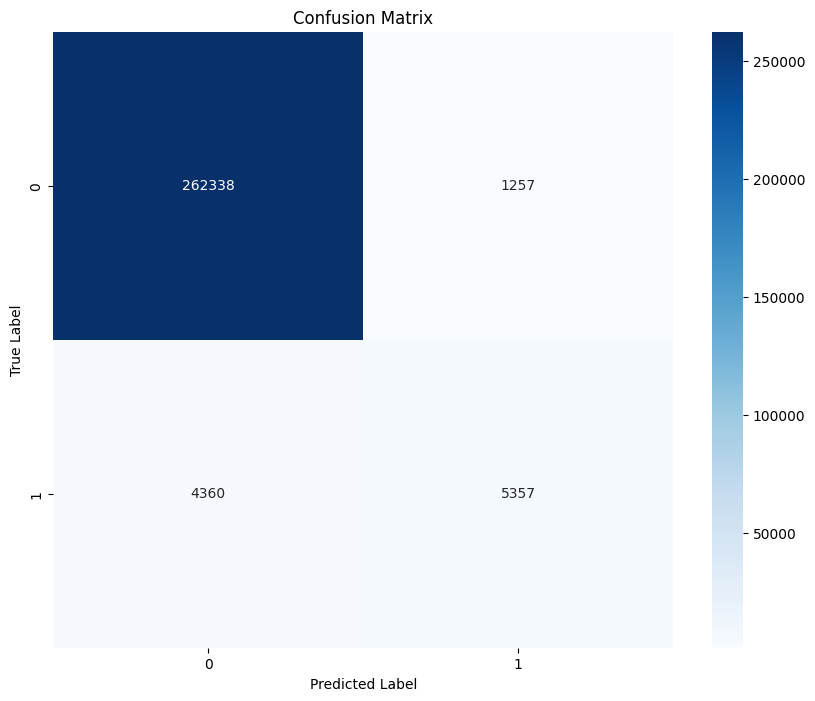

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

logistic_reg_model = LogisticRegression()
multi_classifer = MultiOutputClassifier(logistic_reg_model)
train_labels = filtered_train_target.astype(int)
validation_labels = filtered_val_target.astype(int)
multi_classifer.fit(embeddings_train, train_labels)
predictions = multi_classifer.predict(embeddings_val)

accuracy = accuracy_score(validation_labels, predictions)
print(f"Validation Accuracy: {accuracy:.4f}")

cm = confusion_matrix(validation_labels.flatten(), predictions.flatten())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

